# Filenames

In [18]:

output_dir_prefix = "output/A100/"

baseline_variants_patch16 = {
    "deit_small_patch16_LS" : "APE",
    "rope_mixed_deit_small_patch16_LS" : "RoPE-Mixed",
    "cayleySTRING_regular_deit_small_patch16_LS"   : "Cayley-STRING",
    "cayleySTRING_reflection_deit_small_patch16_LS" : "Cayley-STRING Reflection",
    "cayleySTRING_sparse_learnable_deit_small_patch16_LS_USE_sparse_constraint" : "Cayley-STRING Sparse (f=learnable)",
    # also include the fixed f variant w optimal accuracy!
}

sparse_fixed_f_variants = {
    "cayleySTRING_sparse_fixed5pct_deit_small_patch16_LS" : "Cayley-STRING Sparse (f=5 pct)",
    "cayleySTRING_sparse_fixed10pct_deit_small_patch16_LS" : "Cayley-STRING Sparse (f=10 pct)",
    "cayleySTRING_sparse_fixed15pct_deit_small_patch16_LS" : "Cayley-STRING Sparse (f=15 pct)",
    "cayleySTRING_sparse_fixed20pct_deit_small_patch16_LS" : "Cayley-STRING Sparse (f=20 pct)",
    "cayleySTRING_sparse_fixed25pct_deit_small_patch16_LS" : "Cayley-STRING Sparse (f=25 pct)",
    "cayleySTRING_sparse_fixed30pct_deit_small_patch16_LS" : "Cayley-STRING Sparse (f=30 pct)",
    "cayleySTRING_sparse_fixed35pct_deit_small_patch16_LS" : "Cayley-STRING Sparse (f=35 pct)",
    "cayleySTRING_sparse_fixed40pct_deit_small_patch16_LS" : "Cayley-STRING Sparse (f=40 pct)",
    "cayleySTRING_sparse_fixed45pct_deit_small_patch16_LS" : "Cayley-STRING Sparse (f=45 pct)",
}

sparse_learnable_variants = {
    "cayleySTRING_sparse_learnable_deit_small_patch16_LS_USE_sparse_constraint": "Cayley-STRING Sparse (f=learnable)",
    "cayleySTRING_sparse_learnable_deit_small_patch16_LS" : "Cayley-STRING Sparse (f=learnable, no sparsity constraint)",
}


eval_file = "eval.txt"
log_file = "log.txt"
training_time_file = "training_time.txt"

eval_input_sizes_16 = [224]
eval_input_sizes_8 = [224]

datasets = ["CIFAR10", "MNIST"]
patch_sizes = ["patch16"]

In [24]:
import matplotlib.pyplot as plt
import json
import numpy as np

# Validation Loss Curves

output/A100/CIFAR10/deit_small_patch16_LS/log.txt
output/A100/CIFAR10/rope_mixed_deit_small_patch16_LS/log.txt
output/A100/CIFAR10/cayleySTRING_regular_deit_small_patch16_LS/log.txt
output/A100/CIFAR10/cayleySTRING_reflection_deit_small_patch16_LS/log.txt
output/A100/CIFAR10/cayleySTRING_sparse_learnable_deit_small_patch16_LS_USE_sparse_constraint/log.txt
output/A100/MNIST/deit_small_patch16_LS/log.txt
output/A100/MNIST/rope_mixed_deit_small_patch16_LS/log.txt
output/A100/MNIST/cayleySTRING_regular_deit_small_patch16_LS/log.txt
output/A100/MNIST/cayleySTRING_reflection_deit_small_patch16_LS/log.txt
output/A100/MNIST/cayleySTRING_sparse_learnable_deit_small_patch16_LS_USE_sparse_constraint/log.txt


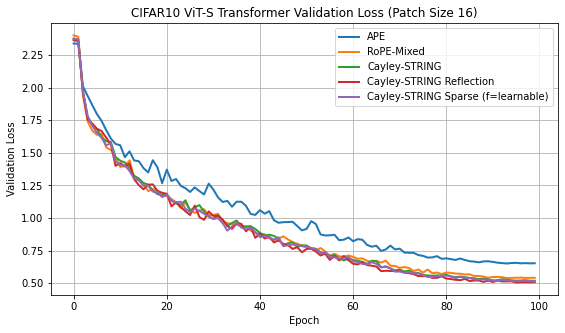

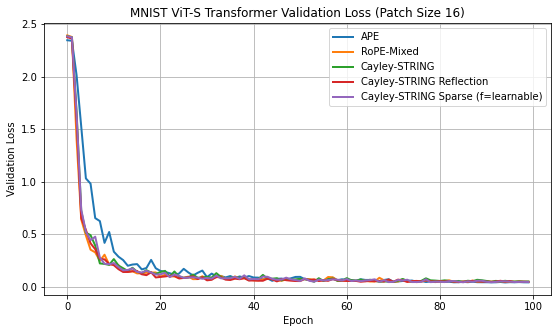

In [19]:
for dataset in datasets: 
    fig = plt.figure(figsize=(20,5))
    axes = fig.add_subplot(1,2,1)
    for model_name, model_label in baseline_variants_patch16.items():
        log_filepath = output_dir_prefix + dataset + "/" + model_name + "/" + log_file
        print(log_filepath)
        with open(log_filepath) as f:
            log_data = f.read()

        # reconstructing data as a dictionary
        log_data = "[" + log_data.replace("}", "},\n").strip(",\n") + "]"

        # Parse the corrected JSON
        log_data = json.loads(log_data)
        
        filtered_log_data = {}
        epoch = 0
        for log_dict in log_data:
            # need to manually correct if there are repeated epochs
            assert epoch == log_dict["epoch"] 
            test_loss =  log_dict["test_loss"]

            filtered_log_data[log_dict["epoch"]] = test_loss
            epoch += 1

        filtered_log_data = dict(sorted(filtered_log_data.items()))

        # Plot eval
        epochs = list(filtered_log_data.keys())
        val_loss_ls = list(filtered_log_data.values())
        axes.plot(epochs,val_loss_ls,'-',label=model_label, linewidth=2) 

    axes.legend(loc='best')
    axes.set_xlabel("Epoch")
    axes.set_ylabel("Validation Loss")
    axes.set_title(f"{dataset} ViT-S Transformer Validation Loss (Patch Size 16)")


    axes.grid()
plt.show()   


# Accuracy

/tmp/ipykernel_1811556/1452149053.py:74: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


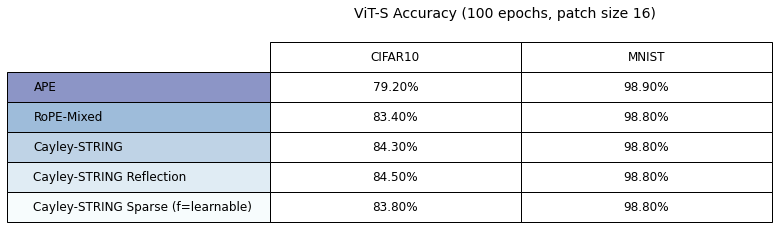

In [40]:
accuracy_contents = []
rows = []

for model_name, model_label in baseline_variants_patch16.items():
    model_accuracies = []
    for dataset in datasets:
        eval_filepath = output_dir_prefix + dataset + "/" + model_name + "/" + eval_file
        try:
            with open(eval_filepath) as f:
                eval_data = f.read()

            # reconstructing data as a dictionary
            eval_data = "[" + eval_data.replace("}", "},\n").strip(",\n") + "]"

            # Parse the corrected JSON
            eval_data = json.loads(eval_data)

            acc1_found = False
            for eval_dict in eval_data:
                # only include valid eval (100 epochs)
                if (eval_dict["epochs"] == 100) and (eval_dict["input_size"] == 224): 
                    acc1 = eval_dict["acc1"]
                    # Remove % sign if present
                    if isinstance(acc1, str):
                        acc1 = acc1.rstrip("%")
                    model_accuracies.append(f"{float(acc1):.2f}%")
                    acc1_found = True
                    break
            if not acc1_found:
                model_accuracies.append("N/A")
        except:
            model_accuracies.append("N/A")
    
    accuracy_contents.append(model_accuracies)
    rows.append(model_label)

# setup table with accuracy
cols = datasets

fig, axs = plt.subplots(figsize=(6, 4))

colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows))) 
n_rows = len(accuracy_contents) 

# Plot line plots and create text labels  
# for the table 
cell_text = [] 
for row in range(n_rows): 
    y_offset = accuracy_contents[row] 
    cell_text.append(y_offset) 

# Reverse colors and text labels to display 
# the last value at the top. 
colors = colors[::-1] 

# Add a table at the bottom of the axes 
table = axs.table(cellText=cell_text, 
                    rowLabels=rows, 
                    rowColours=colors, 
                    colLabels=cols, 
                    loc='center',
                    cellLoc='center') 

# Increase cell padding and height
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 2.5)

# Adjust layout to make room for the table: 
axs.axis('off')
axs.axis('tight')
axs.set_title(f'ViT-S Accuracy (100 epochs, patch size 16)',loc='left', fontsize=14) 

plt.tight_layout()
plt.show()

# Training Speed

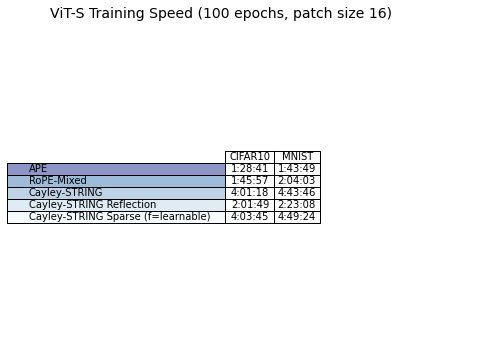

In [37]:
training_speed_contents = []
rows = []

for model_name, model_label in baseline_variants_patch16.items():
    model_training_times = []
    for dataset in datasets:
        training_filepath = output_dir_prefix + dataset + "/" + model_name + "/" + training_time_file
        try:
            with open(training_filepath) as f:
                training_speed_data = f.read()

            # reconstructing data as a dictionary
            training_speed_data = "[" + training_speed_data.replace("}", "},\n").strip(",\n") + "]"

            # Parse the corrected JSON
            training_speed_data = json.loads(training_speed_data)

            time_found = False
            for training_speed_dict in training_speed_data:
                # only include valid training (100 epochs)
                if (training_speed_dict["end_epoch"] == 100) and (training_speed_dict["start_epoch"] == 0): 
                    model_training_times.append(training_speed_dict["training_time_str"])
                    time_found = True
                    break
            if not time_found:
                model_training_times.append("N/A")
        except:
            model_training_times.append("N/A")
    
    training_speed_contents.append(model_training_times)
    rows.append(model_label)

# setup table with training speed
cols = datasets

fig, axs = plt.subplots(figsize=(8, 6))

colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows))) 
n_rows = len(training_speed_contents) 

# Plot line plots and create text labels  
# for the table 
cell_text = [] 
for row in range(n_rows): 
    y_offset = training_speed_contents[row] 
    cell_text.append(y_offset) 

# Reverse colors and text labels to display 
# the last value at the top. 
colors = colors[::-1] 

# Add a table at the bottom of the axes 
table = axs.table(cellText=cell_text, 
                    rowLabels=rows, 
                    rowColours=colors, 
                    colLabels=cols, 
                    loc='center') 

# Adjust layout to make room for the table: 
axs.axis('off')
axs.axis('tight')
axs.set_title(f'ViT-S Training Speed (100 epochs, patch size 16)',loc='left', fontsize=14) 
table.auto_set_font_size(True)
table.auto_set_column_width(col=list(range(len(cols))))

plt.show()

### CIFAR10

### MNIST

# Inference Speed

### CIFAR10

### MNIST